In [116]:
# 01_read_log

In [117]:
# Force to reload extrernal modules every new cell execution
%reload_ext autoreload
%autoreload 2

In [118]:
### IMPORT ###
from pathlib import Path
import csv
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame, Series
from typing import Union
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.model_selection import GridSearchCV

In [119]:
### LOCAL IMPORT ###
from config import config_reader
from utilities import convert_seconds_to_hours, find_min_max_timestamp

In [120]:
### GLOBALS ###
yaml_config = config_reader.config_read_yaml("config.yml", "config")
log_dir = str(yaml_config["LOG_DIR"])
stats_dir = str(yaml_config["STATS_DIR"])

log_in = "EVENT-LOG_ED.csv" # <-- INPUT: initial event log (EVENT-LOG_ED.csv or EVENT-LOG_ED_TEST.csv)
dic_types = dict(yaml_config["EVENT_LOG_TYPES"]) 

# {"CaseID":object, "ACTIVITY":object, "TIMESTAMP":object, "RESOURCE":object, "ESI": int, "OUTCOME":object, "INPAT-HOSP-DEP":object} # <-- INPUT: event log columns types

# Event log main columns
caseid_col = str(yaml_config["CASEID_COL"])
activity_col = str(yaml_config["ACTIVITY_COL"])
timestamp_col = str(yaml_config["TIMESTAMP_COL"])

# Event log types (stadard or enriched)
std_suffix = str(yaml_config["STD_SUFFIX"])
enr_suffix = str(yaml_config["ENR_SUFFIX"])

# ENG terms
dic_terms = dict(yaml_config["HOSPITAL_TERMS"])

# FUNCTIONS

### Event log translation

In [121]:
def translate_column(df: pd.DataFrame, column_name: str, translation_dict: dict) -> pd.DataFrame:
    """
    Transforms a specified column in a DataFrame using a translation dictionary.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the column to be transformed.
        column_name (str): The name of the column to transform.
        translation_dict (dict): A dictionary containing translation mappings.

    Returns:
        pd.DataFrame: The DataFrame with the transformed column.
    """
    if column_name in df.columns:
        # Apply the translation dictionary to the specified column
        df[column_name] = df[column_name].map(translation_dict).fillna(df[column_name])
    else:
        raise ValueError(f"Column '{column_name}' does not exist in the DataFrame.")
    return df


### Total duration e remaining time

In [122]:
def calculate_durations(df: pd.DataFrame, caseid_col_name:str, timestamp_col_name: str) -> pd.DataFrame:
    """
    Calculate the total duration of each process and the remaining time for each event (in seconds).

    Parameters:
    df (pd.DataFrame): A DataFrame containing a timestamp column and a 'CaseID' column for grouping.
    caseid_col_name (str): The name of the column that contains the 'CaseID' values.
    timestamp_col_name (str): The name of the column that contains the 'TIMESTAMP values.

    Returns:
    pd.DataFrame: The input DataFrame with additional columns for 'CASE_DURATION' and 'REMAINING_TIME'.
    """
    
    # Convert the timestamp column to datetime
    df[timestamp_col_name] = pd.to_datetime(df[timestamp_col_name])
    
    # Calculate the total duration of the process for each CaseID
    df['CASE_DURATION_sec'] = df.groupby(caseid_col_name)[timestamp_col_name].transform(lambda x: (x.max() - x.min()).total_seconds())
    
    # Calculate the remaining time for each row
    df['REMAINING_TIME_sec'] = df.groupby(caseid_col_name)[timestamp_col_name].transform(lambda x: (x.max() - x).dt.total_seconds())
    
    return df

### Stats

In [123]:
def unique_caseid_value_distribution(df: pd.DataFrame, caseid_col_name:str, col_name: str, drop_duplicates: bool = True) -> pd.DataFrame:
    """
    Calculate the distribution of unique values for a specified column for each distinct 'CaseID', and include the count and percentage of each value with respect to the total.

    Parameters:
    df (pd.DataFrame): DataFrame containing the columns 'CaseID' and the specified column.
    caseid_col_name (str): The name of the column that contains the 'CaseID' values.
    col_name (str): The name of the column for which to calculate the distribution.

    Returns:
    pd.DataFrame: DataFrame showing the count and percentage of unique values for the specified column for unique 'CaseID'.
    """
    unique_caseid_df = df
    # Keep only the last occurrence of each CaseID
    if drop_duplicates:
        unique_caseid_df = df.drop_duplicates(subset=caseid_col_name, keep='last')
    
    # Calculate the distribution of the specified column values
    value_counts = unique_caseid_df[col_name].value_counts()
    value_percentages = (value_counts / value_counts.sum() * 100).round(2)
    
    # Combine counts and percentages into a single DataFrame
    value_distribution = pd.DataFrame({
        'Count': value_counts,
        'Percentage': value_percentages
    })
    
    return value_distribution

In [124]:
def plot_column_distribution(dataframe: pd.DataFrame, col_name:str) -> None:
    """
    This function takes a dataframe as input and plots the distribution of ESI levels.
    
    Parameters:
    dataframe (pd.DataFrame): The input dataframe containing an 'ESI' column.
    col_nam (str): Name of the column to be showed.
    """

    dataframe = dataframe.drop_duplicates(subset=["CaseID"])

    # Calculate the distribution of ESI levels
    esi_distribution = dataframe[col_name].value_counts().sort_index()

    # Plot the distribution
    plt.figure(figsize=(10, 6))
    esi_distribution.plot(kind='bar', color='skyblue')
    plt_title = f"Total distribution of the column '{col_name}' values"
    plt.title(plt_title)
    x_title = f"{col_name} values"
    plt.xlabel(x_title)
    plt.ylabel('Frequency (total)')
    plt.xticks(rotation=0)
    plt.grid(axis='y')

    # Show the plot
    plt.show()

### Event log enrichment: CaseID at same time

In [125]:
def count_active_cases_until_dimissione(row: Series, log_df: DataFrame, dimissione_timestamps: Union[Series, DataFrame]) -> int:
    """
    Count the number of active cases for a given row in the event log.

    Parameters:
    - row: Series representing a row of the DataFrame.
    - log_df: DataFrame containing the event log data.
    - dimissione_timestamps: Series mapping each CaseID to its DIMISSIONE timestamp.

    Returns:
    - int: Number of active cases before the given timestamp and not yet discharged.
    """
    # Filter rows with earlier timestamps and not yet discharged
    active_cases = log_df[(log_df['TIMESTAMP'] < row['TIMESTAMP']) & (log_df['CaseID'].map(dimissione_timestamps) > row['TIMESTAMP'])]
    return active_cases['CaseID'].nunique()

### Event log enrichment: hour of the day

In [126]:
def add_hour_column(df: pd.DataFrame, timestamp_column: str) -> pd.DataFrame:
    """
    This function takes a DataFrame and the name of a timestamp column, converts the column to a datetime format, extracts the hour in 24-hour format, and adds it as a new column called 'TIMESTAMP_HH'.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame containing the timestamp column.
    timestamp_column (str): The name of the column containing timestamp values.
    
    Returns:
    pd.DataFrame: The DataFrame with an additional column 'TIMESTAMP_HH' containing the extracted hours.
    """
    # Convert the specified column to datetime format
    df[timestamp_column] = pd.to_datetime(df[timestamp_column])
    
    # Extract the hour in 24-hour format and add it as a new column
    df['TIMESTAMP_HH'] = df[timestamp_column].dt.hour
    
    return df

### Event log enrichment: clustering with DBSCAN

In [127]:
def preprocess_eventlog_dbscan(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess the input DataFrame by extracting unique values for specific columns based on each distinct 'CaseID'. The unique values are combined into a single string for each column.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing at least the columns 'CaseID', 'ESI', 'OUTCOME', 'INPAT-HOSP-DEP', and 'CASE_DURATION_sec'.

    Returns:
    pd.DataFrame: A new DataFrame where each 'CaseID' has unique values of  'ESI', 'OUTCOME', 'INPAT-HOSP-DEP', and 'CASE_DURATION_sec' combined into strings.
    """
    
    # Group the DataFrame by 'CaseID' and aggregate using a custom lambda function
    # which joins unique values into a string
    df_processed = df.groupby('CaseID').agg({
        'ESI': lambda x: ','.join(map(str, x.unique())),
        'OUTCOME': lambda x: ','.join(map(str, x.unique())),
        'INPAT-HOSP-DEP': lambda x: ','.join(map(str, x.unique()))
        # 'CASE_DURATION_sec': lambda x: ','.join(map(str, x.unique()))
    }).reset_index()
    
    # Return the processed DataFrame
    return df_processed

In [128]:
def dbscan_clustering(df: pd.DataFrame, numerical_features: list, categorical_features: list, eps: float = 0.5, min_samples: int = 5) -> pd.DataFrame:
    """
    Perform DBSCAN clustering on a DataFrame using specified numerical and categorical features.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame containing the features for clustering.
    numerical_features (list): A list of column names representing numerical features.
    categorical_features (list): A list of column names representing categorical features.
    eps (float): The maximum distance between two samples for one to be considered as in the neighbourhood of the other. Default is 0.5.
    min_samples (int): The number of samples in a neighbourhood for a point to be considered as a core point. Default is 5.
    
    Returns:
    pd.DataFrame: The DataFrame with an added 'cluster' column representing cluster labels.
    """    

    # Extract numerical features and scale them
    if len(numerical_features) > 0:
        X_numeric = df[numerical_features].values
        X_numeric_scaled = StandardScaler().fit_transform(X_numeric)
    else:
        X_numeric_scaled = np.empty((df.shape[0], 0))

    # Encode categorical features
    label_encoders = {}
    X_categorical = []
    for feature in categorical_features:
        le = LabelEncoder()
        df[feature] = le.fit_transform(df[feature])
        X_categorical.append(df[[feature]].values)
        label_encoders[feature] = le
    
    # Combine numerical and encoded categorical features
    X = X_numeric_scaled
    for cat in X_categorical:
        X = np.hstack((X, cat))
    
    # Perform DBSCAN clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(X)
    
    # Add the cluster labels to the DataFrame
    df['CLUSTER'] = clusters
    
    return df

In [129]:
def optimise_dbscan(X, eps_range, min_samples_range, max_evals=100):
    def objective(params):
        # Create the DBSCAN model with the given parameters
        dbscan = DBSCAN(eps=params['eps'], min_samples=int(params['min_samples']))
        
        # Fit and predict the clusters
        labels = dbscan.fit_predict(X)
        
        # Calculate silhouette score, ensuring we have more than one cluster
        if len(set(labels)) > 1 and len(set(labels)) != len(X):
            score = silhouette_score(X, labels)
        else:
            score = -1  # Poor score if all points are noise or all in one cluster
        
        return {'loss': -score, 'status': STATUS_OK}
    
    # Define the search space
    space = {
        'eps': hp.uniform('eps', eps_range[0], eps_range[1]),
        'min_samples': hp.quniform('min_samples', min_samples_range[0], min_samples_range[1], 1)
    }

    # Optimise using the Tree of Parzen Estimators algorithm
    trials = Trials()
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=max_evals, trials=trials)

    return best

In [130]:
def dbscan_grid_search(X, eps_values, min_samples_values):
    # Define a custom scorer using silhouette score
    def custom_scorer(estimator, X):
        labels = estimator.fit_predict(X)
        # Filter out noise points (-1) for silhouette score calculation
        if len(set(labels)) > 1 and len(set(labels)) != len(X):
            return silhouette_score(X, labels)
        else:
            return -1  # Poor score if all points are noise or all in one cluster

    # Create DBSCAN model
    dbscan = DBSCAN()

    # Create parameter grid
    param_grid = {
        'eps': eps_values,
        'min_samples': min_samples_values
    }

    # Create GridSearchCV object
    grid_search = GridSearchCV(dbscan, param_grid, scoring=custom_scorer, cv=[(slice(None), slice(None))], n_jobs=-1)

    # Perform grid search
    grid_search.fit(X)

    # Get the best parameters and the best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    return best_params, best_score

In [131]:
def count_active_cases_by_esi(row: Series, log_df: DataFrame, dimissione_timestamps: Series) -> dict:
    """
    Count the number of active cases for each ESI level for a given row in the event log.

    Parameters:
    - row: Series representing a row of the DataFrame.
    - log_df: DataFrame containing the event log data.
    - dimissione_timestamps: Series mapping each CaseID to its DIMISSIONE timestamp.

    Returns:
    - Dict[int, int]: Dictionary with ESI levels as keys and counts of active cases as values.
    """
    # Filter active cases based on the timestamp and dimissione status
    active_cases = log_df[(log_df['TIMESTAMP'] < row['TIMESTAMP']) & (log_df['CaseID'].map(dimissione_timestamps) > row['TIMESTAMP'])]

    # Count active cases for each ESI level
    active_esi_counts = active_cases.groupby('ESI')['CaseID'].nunique().to_dict()

    # Ensure all ESI levels have a count, even if zero
    esi_counts = {esi: active_esi_counts.get(esi, 0) for esi in range(1, 6)}
    return esi_counts

# MAIN

In [132]:
### MAIN ###
print()
print("*** PROGRAM START ***")
print()

start_time = datetime.now().replace(microsecond=0)
print("Start process:", str(start_time))
print()

# print(yaml_config) # debug


*** PROGRAM START ***

Start process: 2024-08-22 19:52:02



In [133]:
print(">> Creating output directories")
directory_path = Path(stats_dir) # <-- Specify the directory to be created
# Create the directory
directory_path.mkdir(parents=True, exist_ok=True)
print(f"Directory '{directory_path}' created successfully.")

>> Creating output directories
Directory 'stats' created successfully.


In [134]:
print(">> Reading initial event log")
path_data = Path(log_dir) / log_in
print("File:", path_data)
df_log = pd.read_csv(path_data, sep=",", dtype=dic_types)
total_cases = df_log[caseid_col].nunique()
print("Event log shape:", df_log.shape)
print("Event log cases:", total_cases)

>> Reading initial event log
File: data_log/EVENT-LOG_ED.csv
Event log shape: (20624, 7)
Event log cases: 3478


In [135]:
print(">> Distinct values")
for col_name in df_log.columns:
    if col_name == timestamp_col or col_name == caseid_col:
        continue
    print("Column:", col_name)
    data_list = sorted(df_log[col_name].unique().tolist())
    data_list_len = len(data_list)
    print(f"Column data unique values ({data_list_len}): {data_list}")
    print()

>> Distinct values
Column: ACTIVITY
Column data unique values (60): ['ALTRA INTUBAZIONE DEL TRATTO RESPIRATORIO (INSERZIONE STENT)', 'ALTRI INTERVENTI SULLA TRACHEA', 'ARCATA DENTARIA COMPLETA (SUP O INF)', 'ASPORTAZIONE O DEMOLIZIONE ENDOSCOPICA DI LESIONE O TESSUTO NEI BRONCHI', 'BICARBONATO DIALISI', 'BIOPSIA LINFONODO', 'BIOPSIA/CITOLOGIA BRONCHIALE', 'BRONCOSCOPIA CON FIBRE OTTICHE', 'BRONCOSCOPIA RIGIDA', 'COLONSCOPIA CON ENDOSCOPIO FLESSIBILE', 'CONSULENZA', 'CONTROLLI PRETRASF.', 'CONTROLLO NEFROLOGICO', 'CONTROLLO PM-ICD-LOOP', 'DIMISSIONE', 'ECG', 'ECO-DOPPLER ARTERIOSO ARTI INF.', 'ECO-DOPPLER TRONCHI SOVRAORTICI', 'ECO-DOPPLER VENOSO ARTI INF.', 'ECOGRAF.ADDOME COMPLETO', 'ECOGRAF.RENOVESCICALE', 'ECOGRAFIA ADDOME INFERIORE', 'ECOGRAFIA ADDOME SUP.', 'ECOGRAFIA CUTE E TESSUTO', 'ECOGRAFIA MUSCOLO TENDINEA', 'ECOGRAFIA PENIENA', 'ECOGRAFIA SCROTALE/TESTICOLARE', 'EGA VENOSO', 'ELETTROCARDIOGRAMMA', 'ELETTROENCEFALOGRAMMA', 'EMODIAFILTRAZIONE', 'ESOFAGOGASTRODUODENOSCOPIA [EG

In [136]:
print(">> Time span")
dic_min_max_t = find_min_max_timestamp(df_log, timestamp_col)
print(f"Minimum TIMESTAMP value: {dic_min_max_t["min_timestamp"]}")
print(f"Maximum TIMESTAMP value: {dic_min_max_t["max_timestamp"]}")
print()
print(">> Resources")
doc_distinct_count = df_log[df_log['RESOURCE'].str.startswith('DOC')]['RESOURCE'].nunique()
nur_distinct_count = df_log[df_log['RESOURCE'].str.startswith('NUR')]['RESOURCE'].nunique()
print(f"Number of 'DOC': {doc_distinct_count}")
print(f"Number of 'NUR': {nur_distinct_count}")
print()

>> Time span
Minimum TIMESTAMP value: 2022-09-01 00:03:55
Maximum TIMESTAMP value: 2022-10-04 17:19:00

>> Resources
Number of 'DOC': 90
Number of 'NUR': 30



In [137]:
print(">> Event log feature (column) stats")
# Value frequencies
list_col_name = ["OUTCOME", "INPAT-HOSP-DEP", "ACTIVITY"] # <-- INPUT: list of columns
for col_name in list_col_name:
    print("> Column:", col_name)
    if col_name == "ACTIVITY":
        df_freq = unique_caseid_value_distribution(df_log, caseid_col, col_name, False)
    else:
        df_freq = unique_caseid_value_distribution(df_log, caseid_col, col_name, True)
    print(df_freq)
    file_out = f"{col_name}_stats.csv"
    path_out = Path(stats_dir) / file_out
    df_freq.to_csv(path_out, sep=";", quoting=csv.QUOTE_NONNUMERIC)
    print("-"*8)
    print()

>> Event log feature (column) stats
> Column: OUTCOME
                                                  Count  Percentage
OUTCOME                                                            
A domicilio                                        2807       80.71
Ricoverato                                          456       13.11
Non risponde a chiamata                             106        3.05
Chiede di essere dimessa contro il parere medico     34        0.98
Si allontana senza consenso medico                   24        0.69
Trasferito in altra struttura di ricovero            22        0.63
Deceduto in P.S.                                     12        0.35
Rientro in Reparto                                    9        0.26
Rifiuta ricovero                                      6        0.17
Trasferito in altra struttura RSA - RAF ecc           1        0.03
Inserito per errore                                   1        0.03
--------

> Column: INPAT-HOSP-DEP
                           

>> Distribution of ESI values


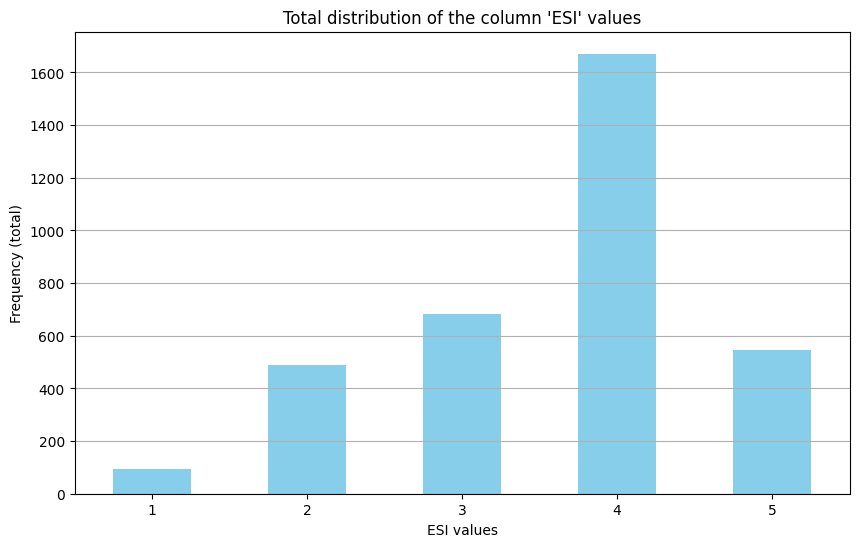

In [138]:
print(">> Distribution of ESI values")
plot_column_distribution(df_log, "ESI")

In [139]:
print(">> Adding case duration and remaining time")
df_log_new = calculate_durations(df_log, caseid_col, timestamp_col)

>> Adding case duration and remaining time


In [140]:
df_log_new

,CaseID,ACTIVITY,TIMESTAMP,RESOURCE,ESI,OUTCOME,INPAT-HOSP-DEP,CASE_DURATION_sec,REMAINING_TIME_sec
0,2022090001,TRIAGE,2022-09-01 00:03:55,NURS_0,3,A domicilio,-,41105.0,41105.0
1,2022090001,PRESA IN CARICO,2022-09-01 00:22:00,DOCT_0,3,A domicilio,-,41105.0,40020.0
2,2022090001,LABORATORIO,2022-09-01 00:28:21,-,3,A domicilio,-,41105.0,39639.0
3,2022090001,TC CRANIO,2022-09-01 00:38:00,-,3,A domicilio,-,41105.0,39060.0
4,2022090001,TAC,2022-09-01 00:38:00,-,3,A domicilio,-,41105.0,39060.0
...,...,...,...,...,...,...,...,...,...
20619,2022093478,DIMISSIONE,2022-10-01 00:21:00,-,3,A domicilio,-,2562.0,0.0
20620,2022093479,TRIAGE,2022-09-30 23:58:38,NURS_8,4,A domicilio,-,27322.0,27322.0
20621,2022093479,PRESA IN CARICO,2022-10-01 00:51:00,DOCT_1,4,A domicilio,-,27322.0,24180.0
20622,2022093479,LABORATORIO,2022-10-01 01:00:12,-,4,A domicilio,-,27322.0,23628.0


In [141]:
print(">> Event log stats")
df_log_new_stats = df_log_new.drop_duplicates(subset=[caseid_col])
case_duration_mean_sec = df_log_new_stats["CASE_DURATION_sec"].mean().round(3)
case_duration_median_sec = df_log_new_stats["CASE_DURATION_sec"].median().round(3)
case_dur_m, case_dur_h = convert_seconds_to_hours(case_duration_mean_sec)
print("Average case duration (sec):", case_duration_mean_sec)
print("Median case duration (sec):", case_duration_median_sec)
print("Average case duration (min):", case_dur_m.round(3))
print("Average case duration (hours):", case_dur_h.round(3))

df_log_new[timestamp_col] = pd.to_datetime(df_log_new[timestamp_col])
df_log_new['DATE'] = df_log_new[timestamp_col].dt.date
distinct_case_per_day = df_log_new.groupby('DATE')[caseid_col].nunique()
average_distinct_case_per_day = distinct_case_per_day.mean().round(2)
df_log_new = df_log_new.drop(columns=['DATE'])
print("Average CaseID per day:", average_distinct_case_per_day)

>> Event log stats
Average case duration (sec): 27610.9
Median case duration (sec): 10126.0
Average case duration (min): 460.182
Average case duration (hours): 7.67
Average CaseID per day: 128.12


>> Distribution of CASE DURATION by ESI values


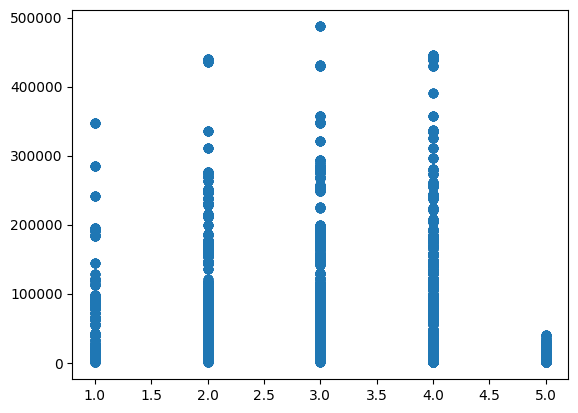

In [142]:
print(">> Distribution of CASE DURATION by ESI values")
esi_vs_case_duration = df_log_new[["ESI", "CASE_DURATION_sec"]]
es, case_duration = esi_vs_case_duration.ESI, esi_vs_case_duration.CASE_DURATION_sec
plt.scatter(es, case_duration)

In [143]:
# Drop the case duration
df_log_new = df_log_new.drop('CASE_DURATION_sec', axis=1)

In [144]:
print(">> Saving event log with duration")
log_out = f"{Path(log_in).stem}_duration_{std_suffix}.csv"
path_out = Path(log_dir) / log_out
print("File:", path_out)
df_log_new.to_csv(path_out, sep=";", index=False)

>> Saving event log with duration
File: data_log/EVENT-LOG_ED_duration_std.csv


### LOG in ENG

In [145]:
print(">> Creating event log with ENG values")
df_log_eng = translate_column(df_log, activity_col, dic_terms)
print("> Saving ENG version")
log_out = f"{Path(log_in).stem}_ENG.csv"
path_out = Path(log_dir) / log_out
print("File:", path_out)
df_log_eng.to_csv(path_out, sep=";", index=False)

>> Creating event log with ENG values
> Saving ENG version
File: data_log/EVENT-LOG_ED_ENG.csv


### LOG ENRICHMENT

In [146]:
# Prepare the log enrichment starting from the new one (with duration and remaining time)
df_log_new_enr = df_log_new

In [147]:
print(">> Checking TRIAGE and DIMISSIONE counts")

# Counting the number of 'TRIAGE' and 'DIMISSIONE'
num_triage = df_log_new[df_log_new[activity_col] == 'TRIAGE'].shape[0]
num_dimissione = df_log_new[df_log_new[activity_col] == 'DIMISSIONE'].shape[0]

# Check whether there are any CaseIDs without a corresponding 'DIMISSIONE'.
case_ids_with_triage = set(df_log_new[df_log_new[activity_col] == 'TRIAGE']['CaseID'])
case_ids_with_dimissione = set(df_log_new[df_log_new[activity_col] == 'DIMISSIONE']['CaseID'])

# CaseID without a corresponding 'DIMISSION'
case_ids_without_dimissione = case_ids_with_triage - case_ids_with_dimissione

num_triage, num_dimissione, len(case_ids_without_dimissione), list(case_ids_without_dimissione)[:10]

print("TRIAGE:", num_triage)
print("DIMISSIONE:", num_dimissione)
print(f"CASES without DIMISSIONE ({len(case_ids_without_dimissione)}): {list(case_ids_without_dimissione)[:10]}")

>> Checking TRIAGE and DIMISSIONE counts
TRIAGE: 3478
DIMISSIONE: 3478
CASES without DIMISSIONE (0): []


In [148]:
print(">> Event log enrichment")
print("> Active cases")
# Get the latest DIMISSIONE timestamp for each CaseID
dimissione_timestamps = df_log_new_enr[df_log_new_enr[activity_col] == 'DIMISSIONE'].groupby(caseid_col)[timestamp_col].max()
df_log_new_enr['ACTIVE_CaseID'] = df_log_new.apply(lambda row: count_active_cases_until_dimissione(row, df_log_new_enr, dimissione_timestamps), axis=1)

>> Event log enrichment
> Active cases


In [149]:
print(">> Adding HOUR")
df_log_new_enr = add_hour_column(df_log_new_enr, "TIMESTAMP")

>> Adding HOUR


In [150]:
print(">> Adding active ESI")
# Apply the function to each row and expand into separate columns
esi_counts = df_log_new_enr.apply(lambda row: count_active_cases_by_esi(row, df_log_new_enr, dimissione_timestamps), axis=1)
esi_counts_df = pd.DataFrame(esi_counts.tolist(), index=df_log_new_enr.index)
esi_counts_df.columns = [f'COUNT-ESI-{esi}' for esi in esi_counts_df.columns]
# Concatenate the new columns to the original dataframe
df_log_new_enr = pd.concat([df_log_new_enr, esi_counts_df], axis=1)
print(df_log_new_enr.shape)

>> Adding active ESI
(20624, 15)


In [151]:
df_log_new_enr

,CaseID,ACTIVITY,TIMESTAMP,RESOURCE,ESI,OUTCOME,INPAT-HOSP-DEP,REMAINING_TIME_sec,ACTIVE_CaseID,TIMESTAMP_HH,COUNT-ESI-1,COUNT-ESI-2,COUNT-ESI-3,COUNT-ESI-4,COUNT-ESI-5
0,2022090001,TRIAGE,2022-09-01 00:03:55,NURS_0,3,A domicilio,-,41105.0,0,0,0,0,0,0,0
1,2022090001,PRESA IN CARICO,2022-09-01 00:22:00,DOCT_0,3,A domicilio,-,40020.0,2,0,0,0,1,1,0
2,2022090001,LABORATORIO,2022-09-01 00:28:21,-,3,A domicilio,-,39639.0,2,0,0,0,1,1,0
3,2022090001,TC CRANIO,2022-09-01 00:38:00,-,3,A domicilio,-,39060.0,2,0,0,0,1,1,0
4,2022090001,TAC,2022-09-01 00:38:00,-,3,A domicilio,-,39060.0,2,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20619,2022093478,DIMISSIONE,2022-10-01 00:21:00,-,3,A domicilio,-,0.0,27,0,5,8,7,7,0
20620,2022093479,TRIAGE,2022-09-30 23:58:38,NURS_8,4,A domicilio,-,27322.0,31,23,5,8,8,9,1
20621,2022093479,PRESA IN CARICO,2022-10-01 00:51:00,DOCT_1,4,A domicilio,-,24180.0,27,0,5,8,7,7,0
20622,2022093479,LABORATORIO,2022-10-01 01:00:12,-,4,A domicilio,-,23628.0,27,1,5,8,7,7,0


In [152]:
print(">> Applying DBSCAN")
print("> Preparing the event log for DBSCAN")
X = preprocess_eventlog_dbscan(df_log_new_enr) # X is the matrix in which search the clusters

>> Applying DBSCAN
> Preparing the event log for DBSCAN


In [153]:
X

,CaseID,ESI,OUTCOME,INPAT-HOSP-DEP
0,2022090001,3,A domicilio,-
1,2022090002,4,A domicilio,-
2,2022090003,4,A domicilio,-
3,2022090004,3,A domicilio,-
4,2022090005,4,A domicilio,-
...,...,...,...,...
3473,2022093475,2,Ricoverato,CARDIOLOGIA RO
3474,2022093476,5,A domicilio,-
3475,2022093477,1,Trasferito in altra struttura di ricovero,-
3476,2022093478,3,A domicilio,-


In [154]:
print("> Clustering with DBSCAN")
# eps, min_samples = best_params["eps"], best_params["min_samples"]
eps = 0.6477958755453274
min_samples = 240
# df_clustered = dbscan_clustering(X, ['CASE_DURATION_sec'], ['ESI', 'OUTCOME', 'INPAT-HOSP-DEP'])
df_clustered = dbscan_clustering(X, [], ['ESI', 'OUTCOME', 'INPAT-HOSP-DEP'])

> Clustering with DBSCAN


In [155]:
df_clustered_filter = df_clustered[[caseid_col, "CLUSTER"]] # Removes duplicate columns (features)
df_clustered

,CaseID,ESI,OUTCOME,INPAT-HOSP-DEP,CLUSTER
0,2022090001,2,0,0,0
1,2022090002,3,0,0,1
2,2022090003,3,0,0,1
3,2022090004,2,0,0,0
4,2022090005,3,0,0,1
...,...,...,...,...,...
3473,2022093475,1,5,1,7
3474,2022093476,4,0,0,5
3475,2022093477,0,10,0,26
3476,2022093478,2,0,0,0


In [156]:
print(f"Clusters found (count): {df_clustered["CLUSTER"].nunique()} over {total_cases} total cases")
print("Clusters found (list):", sorted(df_clustered["CLUSTER"].unique().tolist()))

Clusters found (count): 47 over 3478 total cases
Clusters found (list): [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]


In [157]:
df_clustered["CLUSTER"].value_counts()
# -1 -> outliers

CLUSTER
 1     1476
 0      519
 5      475
 8      312
-1      130
 4       55
 11      49
 16      27
 10      25
 18      25
 13      21
 20      18
 30      18
 15      16
 14      16
 32      15
 35      13
 7       12
 29      12
 19      12
 41      12
 27      12
 44      12
 23      12
 24      11
 45      11
 21      10
 33      10
 34      10
 36      10
 37      10
 25       9
 12       9
 26       9
 17       8
 31       8
 39       7
 3        7
 40       7
 22       7
 28       7
 38       6
 9        6
 42       6
 2        6
 43       5
 6        5
Name: count, dtype: int64

In [158]:
# Evaluate the clustering
silhouette_score(X, df_clustered['CLUSTER'])

-0.3965806922725391

In [159]:
# Add the clusters to event log
df_log_new_enr = pd.merge(left=df_log_new_enr, right=df_clustered_filter, on=caseid_col, how="left")

In [160]:
df_log_new_enr

,CaseID,ACTIVITY,TIMESTAMP,RESOURCE,ESI,OUTCOME,INPAT-HOSP-DEP,REMAINING_TIME_sec,ACTIVE_CaseID,TIMESTAMP_HH,COUNT-ESI-1,COUNT-ESI-2,COUNT-ESI-3,COUNT-ESI-4,COUNT-ESI-5,CLUSTER
0,2022090001,TRIAGE,2022-09-01 00:03:55,NURS_0,3,A domicilio,-,41105.0,0,0,0,0,0,0,0,0
1,2022090001,PRESA IN CARICO,2022-09-01 00:22:00,DOCT_0,3,A domicilio,-,40020.0,2,0,0,0,1,1,0,0
2,2022090001,LABORATORIO,2022-09-01 00:28:21,-,3,A domicilio,-,39639.0,2,0,0,0,1,1,0,0
3,2022090001,TC CRANIO,2022-09-01 00:38:00,-,3,A domicilio,-,39060.0,2,0,0,0,1,1,0,0
4,2022090001,TAC,2022-09-01 00:38:00,-,3,A domicilio,-,39060.0,2,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20619,2022093478,DIMISSIONE,2022-10-01 00:21:00,-,3,A domicilio,-,0.0,27,0,5,8,7,7,0,0
20620,2022093479,TRIAGE,2022-09-30 23:58:38,NURS_8,4,A domicilio,-,27322.0,31,23,5,8,8,9,1,1
20621,2022093479,PRESA IN CARICO,2022-10-01 00:51:00,DOCT_1,4,A domicilio,-,24180.0,27,0,5,8,7,7,0,1
20622,2022093479,LABORATORIO,2022-10-01 01:00:12,-,4,A domicilio,-,23628.0,27,1,5,8,7,7,0,1


In [161]:
"""
print("> Optimizing DBSCAN")
eps_range = (0.001, 1.0)  # Range for epsilon
print("EPS range:", eps_range)
min_samples_range = (1, 500)  # Range for min_samples
print("Min samples range:", min_samples_range)
best_params = optimise_dbscan(X, eps_range, min_samples_range)
print("Best parameters for DBSCAN:", best_params)
"""

'\nprint("> Optimizing DBSCAN")\neps_range = (0.001, 1.0)  # Range for epsilon\nprint("EPS range:", eps_range)\nmin_samples_range = (1, 500)  # Range for min_samples\nprint("Min samples range:", min_samples_range)\nbest_params = optimise_dbscan(X, eps_range, min_samples_range)\nprint("Best parameters for DBSCAN:", best_params)\n'

In [162]:
"""
eps_values = [i * 0.001 for i in range(1, 1001)]
# print(eps_values)
min_samples_values = list(range(1, 500))
# print(min_samples_values)

best_params, best_score = dbscan_grid_search(X, eps_values, min_samples_values)
print("Best Parameters:", best_params)
print("Best Score:", best_score)
"""

'\neps_values = [i * 0.001 for i in range(1, 1001)]\n# print(eps_values)\nmin_samples_values = list(range(1, 500))\n# print(min_samples_values)\n\nbest_params, best_score = dbscan_grid_search(X, eps_values, min_samples_values)\nprint("Best Parameters:", best_params)\nprint("Best Score:", best_score)\n'

In [163]:
# best_dict

In [164]:
print(">> Saving event log enriched")
log_out = f"{Path(log_in).stem}_duration_{enr_suffix}.csv"
path_out = Path(log_dir) / log_out
print("File:", path_out)
df_log_new_enr.to_csv(path_out, sep=";", index=False)

>> Saving event log enriched
File: data_log/EVENT-LOG_ED_duration_enr.csv


In [165]:
# program end
end_time = datetime.now().replace(microsecond=0)
delta_time = end_time - start_time

print("End process:", end_time)
print("Time to finish:", delta_time)

print()
print("*** PROGRAM END ***")
print()

End process: 2024-08-22 19:52:35
Time to finish: 0:00:33

*** PROGRAM END ***

